<div align="center">

# **Analisis Exploratorio**

</div>

## Librerias

In [242]:
library(dplyr)

## Data

In [243]:
df_input <- read.csv("../data/input/Muestra_Siniestros_4.csv")

In [244]:
names(df_input)

[1] "Amparo"          "Amp"             "SumaDePagos"     "Modelo"         
 [5] "Color"           "Carroceria"      "MARCA"           "Referencia1"    
 [9] "Referencia2"     "CLASE_FASECOLDA" "TIPO_VEHICULO"   "SERVICIO"       
[13] "Sexo_Aseg"       "Edad"            "Desde"           "Hasta"          
[17] "Vr_Comercial"    "Pago"

In [245]:
dim(df_input)

[1] 5000   18

In [246]:
glimpse(df_input)

Rows: 5,000
Columns: 18
$ Amparo          <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, "PERDI…
$ Amp             <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, "PPD",…
$ SumaDePagos     <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, 263295…
$ Modelo          <int> 2013, 2010, 2012, 2008, 2008, 2007, 2012, 2007, 2010, …
$ Color           <chr> "ROJO", "PLATA", "PLATA", "BLANCO", "VINO TINTO", "PLA…
$ Carroceria      <chr> "SEDAN", "HATCHBACK", "SEDAN", "SEDAN", "SEDAN", "HATC…
$ MARCA           <chr> "HYUNDAI", "HYUNDAI", "HYUNDAI", "HYUNDAI", "HYUNDAI",…
$ Referencia1     <chr> "VELOSTER", "ATOS [2]", "ACCENT i25", "ATOS [2]", "ACC…
$ Referencia2     <chr> "COUPE", "PRIME", "1.4L", "PRIME", "GLS", "SANTRO", "G…
$ CLASE_FASECOLDA <chr> "AUTOMOVIL", "AUTOMOVIL", "AUTOMOVIL", "AUTOMOVIL TAXI…
$ TIPO_VEHICULO   <chr> "Livianos", "Livianos", "Livianos", "Livianos", "Livia…
$ SERVICIO        <chr> "Particular", "Particular", "Particular", "Particular"…
$ Sexo_Aseg     

## Valores nulos

In [247]:
sum(is.na(df_input))

[1] 13585

hpta

In [248]:
colSums(is.na(df_input))

Amparo             Amp     SumaDePagos          Modelo           Color 
           4320            4320            4320               0               0 
     Carroceria           MARCA     Referencia1     Referencia2 CLASE_FASECOLDA 
              0               0               0               0               0 
  TIPO_VEHICULO        SERVICIO       Sexo_Aseg            Edad           Desde 
              0               0             625               0               0 
          Hasta    Vr_Comercial            Pago 
              0               0               0

## Exploracion de variables

### Amparo, Amp y SumaDePagos

In [249]:
summary(df_input$Amparo)

   Length     Class      Mode 
     5000 character character 

In [250]:
unique(df_input$Amp)

[1] NA    "PPD" "PTD" "RC"  "GT"  "PPH" "PTH" "ASI"

In [251]:
df_amp <- df_input %>% select(Amparo, Amp)

In [252]:
# 1. Tabla de patrones de NA
table(is.na(df_input$Amp), is.na(df_input$Amparo))

# 2. Verificar si siempre coinciden los NA
all(is.na(df_input$Amp) == is.na(df_input$Amparo))

# 3. Contar los diferentes patrones
df_input %>%
  summarise(
    ambos_NA = sum(is.na(Amp) & is.na(Amparo)),
    ambos_no_NA = sum(!is.na(Amp) & !is.na(Amparo)),
    solo_Amp_NA = sum(is.na(Amp) & !is.na(Amparo)),
    solo_Amparo_NA = sum(!is.na(Amp) & is.na(Amparo))
  )

       
        FALSE TRUE
  FALSE   680    0
  TRUE      0 4320

[1] TRUE

ambos_NA,ambos_no_NA,solo_Amp_NA,solo_Amparo_NA
<int>,<int>,<int>,<int>
4320,680,0,0


Los NA coinciden

Hay que ver que pasa con las perdidas parciales y totales por hurto, porque la correspondecia de las demas variables se ve.

In [253]:
all(is.na(df_input$Amp) == is.na(df_input$SumaDePagos))

df_input %>%
  summarise(
    ambos_NA = sum(is.na(Amp) & is.na(df_input$SumaDePagos)),
    ambos_no_NA = sum(!is.na(Amp) & !is.na(df_input$SumaDePagos)),
    solo_Amp_NA = sum(is.na(Amp) & !is.na(df_input$SumaDePagos)),
    solo_Suma_NA = sum(!is.na(Amp) & is.na(df_input$SumaDePagos))
  )

[1] TRUE

ambos_NA,ambos_no_NA,solo_Amp_NA,solo_Suma_NA
<int>,<int>,<int>,<int>
4320,680,0,0


SumaDePagos es NA donde Amp y Amparo es NA

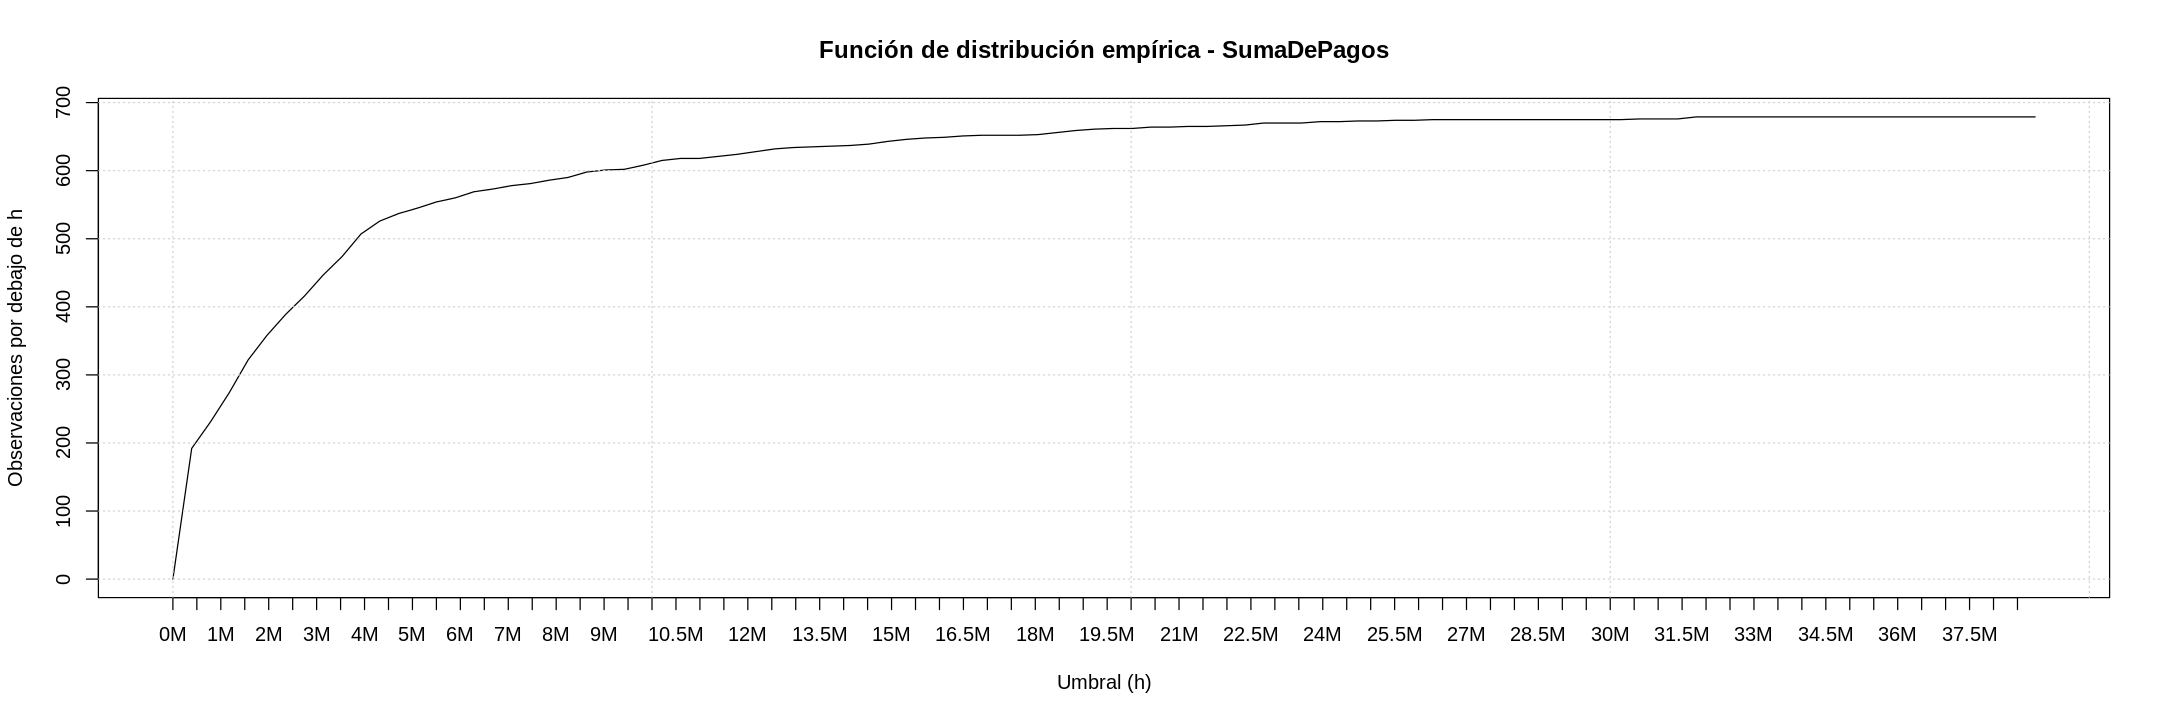

In [254]:
contar_por_debajo <- function(h, data = df_input) {
  sum(data$SumaDePagos < h, na.rm = TRUE)
}

umbrales <- seq(0, max(df_input$SumaDePagos, na.rm = TRUE), length.out = 100)
conteos <- sapply(umbrales, contar_por_debajo)

options(repr.plot.width = 18, repr.plot.height = 6)
par(bg = "white")
plot(umbrales, conteos,
       type = "l",
       xlab = "Umbral (h)",
       ylab = "Observaciones por debajo de h",
       main = "Función de distribución empírica - SumaDePagos",
       bg = "white",
       xaxt = "n")

axis(1, at = seq(0, max(umbrales), by = 500000),
     labels = paste0(seq(0, max(umbrales), by = 500000)/1000000, "M"))
grid()

Hay que escoger un minimo para SumaDePagos cuando vayamos a modelar el la frecuencia.

In [255]:
pago_minimo <- 100000

In [256]:
library(fastDummies)

# Definir pago mínimo
pago_minimo <- 50000  # Ajusta según tu criterio

# Preparar datos
df_dummy <- df_input %>%
  select(Amparo, Amp, SumaDePagos) %>%
  mutate(
    # Convertir NA a "No aplica"
    Amparo = ifelse(is.na(Amparo), "No aplica", Amparo),
    Amp = ifelse(is.na(Amp), "No aplica", Amp),
    # Procesar SumaDePagos
    SumaDePagos = case_when(
      is.na(SumaDePagos) ~ 0,
      SumaDePagos < pago_minimo ~ 0,
      TRUE ~ SumaDePagos
    )
  )

# Crear variables dummy
df_final <- dummy_cols(df_dummy, 
                      select_columns = c("Amparo", "Amp"),
                      remove_first_dummy = FALSE,
                      remove_selected_columns = TRUE)

# Ver estructura
head(df_final)
names(df_final)

,SumaDePagos,Amparo_ASISTENCIA JURIDICA EN PROCESO PENAL,Amparo_GASTOS DE TRANSPORTE POR PERDIDA TOTAL,Amparo_No aplica,Amparo_PERDIDA PARCIAL POR DA�OS,Amparo_PERDIDA PARCIAL POR HURTO,Amparo_PERDIDA TOTAL HURTO,Amparo_PERDIDA TOTAL O PARCIAL POR HURTO,Amparo_PERDIDA TOTAL POR DA�OS,Amparo_RESPONSABILIDAD CIVIL EXTRACONTRACTUAL,Amp_ASI,Amp_GT,Amp_No aplica,Amp_PPD,Amp_PPH,Amp_PTD,Amp_PTH,Amp_RC
,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


[1] "SumaDePagos"                                  
 [2] "Amparo_ASISTENCIA JURIDICA EN PROCESO PENAL"  
 [3] "Amparo_GASTOS DE TRANSPORTE POR PERDIDA TOTAL"
 [4] "Amparo_No aplica"                             
 [5] "Amparo_PERDIDA PARCIAL POR DA�OS"             
 [6] "Amparo_PERDIDA PARCIAL POR HURTO"             
 [7] "Amparo_PERDIDA TOTAL HURTO"                   
 [8] "Amparo_PERDIDA TOTAL O PARCIAL POR HURTO"     
 [9] "Amparo_PERDIDA TOTAL POR DA�OS"               
[10] "Amparo_RESPONSABILIDAD CIVIL EXTRACONTRACTUAL"
[11] "Amp_ASI"                                      
[12] "Amp_GT"                                       
[13] "Amp_No aplica"                                
[14] "Amp_PPD"                                      
[15] "Amp_PPH"                                      
[16] "Amp_PTD"                                      
[17] "Amp_PTH"                                      
[18] "Amp_RC"

Warning message in strwidth(newrownames, cex = tl.cex):
“conversion failure on 'Amparo_PERDIDA PARCIAL POR DA�OS' in 'mbcsToSbcs': dot substituted for <ef>”
Warning message in strwidth(newrownames, cex = tl.cex):
“conversion failure on 'Amparo_PERDIDA PARCIAL POR DA�OS' in 'mbcsToSbcs': dot substituted for <bf>”
Warning message in strwidth(newrownames, cex = tl.cex):
“conversion failure on 'Amparo_PERDIDA PARCIAL POR DA�OS' in 'mbcsToSbcs': dot substituted for <bd>”
Warning message in strwidth(newrownames, cex = tl.cex):
“conversion failure on 'Amparo_PERDIDA TOTAL POR DA�OS' in 'mbcsToSbcs': dot substituted for <ef>”
Warning message in strwidth(newrownames, cex = tl.cex):
“conversion failure on 'Amparo_PERDIDA TOTAL POR DA�OS' in 'mbcsToSbcs': dot substituted for <bf>”
Warning message in strwidth(newrownames, cex = tl.cex):
“conversion failure on 'Amparo_PERDIDA TOTAL POR DA�OS' in 'mbcsToSbcs': dot substituted for <bd>”


Warning message in strwidth(newcolnames, cex = tl.cex):
“conversion failure on 'Amparo_PERDIDA PARCIAL POR DA�OS' in 'mbcsToSbcs': dot substituted for <ef>”
Warning message in strwidth(newcolnames, cex = tl.cex):
“conversion failure on 'Amparo_PERDIDA PARCIAL POR DA�OS' in 'mbcsToSbcs': dot substituted for <bf>”
Warning message in strwidth(newcolnames, cex = tl.cex):
“conversion failure on 'Amparo_PERDIDA PARCIAL POR DA�OS' in 'mbcsToSbcs': dot substituted for <bd>”
Warning message in strwidth(newcolnames, cex = tl.cex):
“conversion failure on 'Amparo_PERDIDA TOTAL POR DA�OS' in 'mbcsToSbcs': dot substituted for <ef>”
Warning message in strwidth(newcolnames, cex = tl.cex):
“conversion failure on 'Amparo_PERDIDA TOTAL POR DA�OS' in 'mbcsToSbcs': dot substituted for <bf>”
Warning message in strwidth(newcolnames, cex = tl.cex):
“conversion failure on 'Amparo_PERDIDA TOTAL POR DA�OS' in 'mbcsToSbcs': dot substituted for <bd>”
Warning message in strwidth(newrownames, cex = tl.cex):
“convers

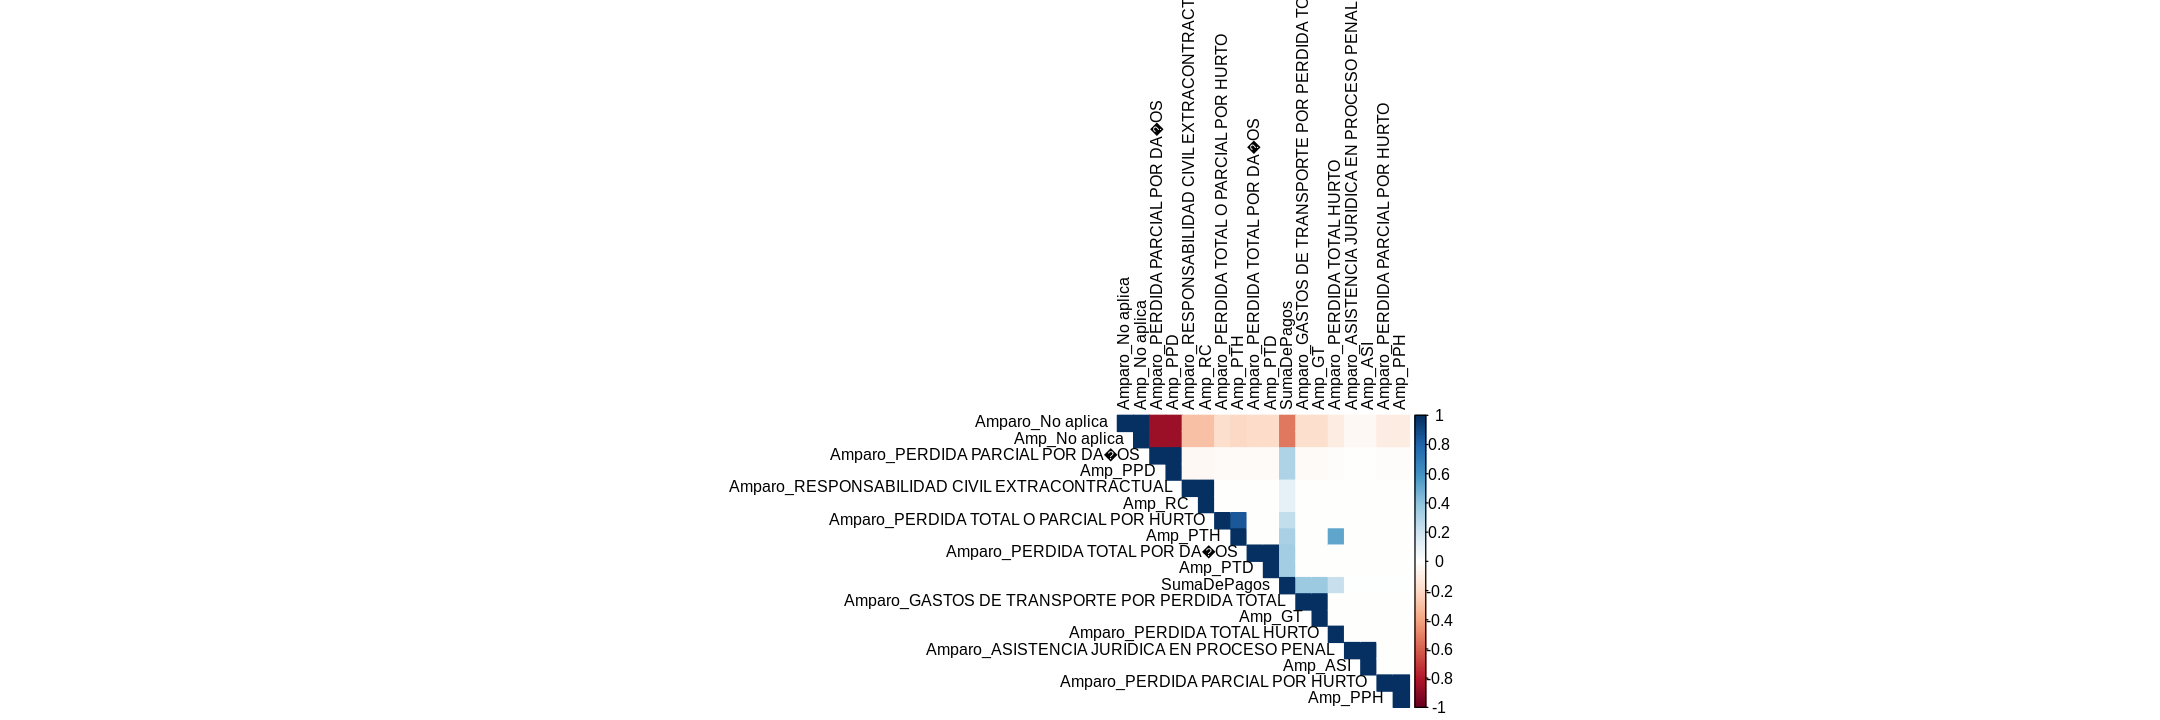

In [257]:
# Matriz de correlaciones
cor_matrix <- cor(df_final)
library(corrplot)
corrplot(cor_matrix, method = "color", type = "upper", 
order = "hclust", tl.cex = 0.8, tl.col = "black")

### Modelo

In [258]:
summary(df_input$Modelo)
table(df_input$Modelo)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1993    2008    2010    2009    2012    2013 


1993 1995 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 
   9   10    9   89   34   49   19   49   32   90  202  189  423  445  489  618 
2011 2012 2013 
 864 1177  203 

accidentados:

In [259]:
df_modelo <- df_input[, c("Modelo", "SumaDePagos")]
df_modelo <- df_modelo[!(df_modelo$SumaDePagos < pago_minimo | is.na(df_modelo$SumaDePagos)), ]
summary(df_modelo$Modelo)
table(df_modelo$Modelo)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1993    2007    2010    2009    2012    2013 


1993 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 
   2    1    9    3    6    3    5    3   11   27   17   44   43   55   71   75 
2012 2013 
 120   19 

### Color

In [260]:
summary(df_input$Color)
table(df_input$Color)

   Length     Class      Mode 
     5000 character character 


       AMARILLO      ARENA FINA            AZUL           BEIGE          BLANCO 
            870               5             431              71             774 
         BRONCE    BRONCE SUAVE            CAFE        CHAMPA�A          DORADO 
             18              15              11              49              24 
           GRIS          MARRON         NARANJA           NEGRO             ORO 
            735               4               7             435              12 
          PLATA        PLATEADO         PLATINO            ROJO TITANIO METALIC 
            902             107               6             384               3 
 UVA METALIZADO           VERDE      VINO TINTO       VINOTINTO         VIOLETA 
              2              92               7              26              10 

Accidentados

In [261]:
df_color <- df_input[, c("Color", "SumaDePagos")]
df_color <- df_color[!(df_color$SumaDePagos < pago_minimo | is.na(df_color$SumaDePagos)), ]
summary(df_color$Color)
table(df_color$Color)

   Length     Class      Mode 
      514 character character 


      AMARILLO           AZUL          BEIGE         BLANCO   BRONCE SUAVE 
            80             46              5             75              1 
          CAFE       CHAMPA�A         DORADO           GRIS         MARRON 
             3              6              1             77              1 
       NARANJA          NEGRO            ORO          PLATA       PLATEADO 
             2             44              2             97             10 
       PLATINO           ROJO UVA METALIZADO          VERDE      VINOTINTO 
             2             45              1             13              3 

### Carroceria

In [262]:
summary(df_input$Carroceria)
table(df_input$Carroceria)

   Length     Class      Mode 
     5000 character character 


                     -             BUS-BUSETA               CABINADO 
                     4                     37                    590 
                 COUPE                ESTACAS                 FURGON 
                    80                     18                     54 
             HATCHBACK               METALICA                  PANEL 
                  1794                     51                      7 
PICK UP - DOBLE CABINA                 PLATON                  SEDAN 
                    25                      3                   2088 
        SIN CARROCERIA              ST. WAGON       VAN DE PASAJEROS 
                     6                    213                     30 

accidentados

In [263]:
df_Carroceria <- df_input[, c("Carroceria", "SumaDePagos")]
df_Carroceria <- df_Carroceria[!(df_Carroceria$SumaDePagos < pago_minimo | is.na(df_Carroceria$SumaDePagos)), ]
summary(df_Carroceria$Carroceria)
table(df_Carroceria$Carroceria)

   Length     Class      Mode 
      514 character character 


            BUS-BUSETA               CABINADO                  COUPE 
                     5                     71                      7 
               ESTACAS                 FURGON              HATCHBACK 
                     1                      5                    187 
              METALICA                  PANEL PICK UP - DOBLE CABINA 
                     6                      1                      3 
                 SEDAN         SIN CARROCERIA              ST. WAGON 
                   198                      1                     24 
      VAN DE PASAJEROS 
                     5 

### Marca

In [264]:
summary(df_input$MARCA)
table(df_input$MARCA)

   Length     Class      Mode 
     5000 character character 


HYUNDAI 
   5000 

Accidentados

In [265]:
df_MARCA <- df_input[, c("MARCA", "SumaDePagos")]
df_MARCA <- df_MARCA[!(df_MARCA$SumaDePagos < pago_minimo | is.na(df_MARCA$SumaDePagos)), ]
summary(df_MARCA$MARCA)
table(df_MARCA$MARCA)

   Length     Class      Mode 
      514 character character 


HYUNDAI 
    514 

A bueno

### Referencia 1

In [266]:
summary(df_input$Referencia1)
table(df_input$Referencia1)

   Length     Class      Mode 
     5000 character character 


                -            ACCENT       ACCENT GYRO        ACCENT i25 
                4               147               157               344 
     ACCENT VERNA     ACCENT VISION     ACCENT WEB II          ATOS [1] 
               58               522                46                11 
    ATOS [1] [FL]          ATOS [2]           ELANTRA    ELANTRA AVANTE 
              134              1236                 9                29 
       ELANTRA FL   ELANTRA SUPREME             EXCEL           GENESIS 
               56                51                 4                23 
         GETZ [1]     GETZ [1] [FL]              H100                HD 
               27               390                19                70 
              i10          i10 [FL]               i30           i30 [2] 
              425                80                13                 2 
      i35 ELANTRA            PORTER      SANTA FE [1]      SANTA FE [2] 
              149                21               

In [267]:
df_Referencia1 <- df_input[, c("Referencia1", "SumaDePagos")]
df_Referencia1 <- df_Referencia1[!(df_Referencia1$SumaDePagos < pago_minimo | is.na(df_Referencia1$SumaDePagos)), ]
summary(df_Referencia1$Referencia1)
table(df_Referencia1$Referencia1)

   Length     Class      Mode 
      514 character character 


           ACCENT       ACCENT GYRO        ACCENT i25      ACCENT VERNA 
               14                18                33                 7 
    ACCENT VISION     ACCENT WEB II          ATOS [1]     ATOS [1] [FL] 
               52                 5                 2                17 
         ATOS [2]           ELANTRA    ELANTRA AVANTE        ELANTRA FL 
              112                 2                 3                 7 
  ELANTRA SUPREME             EXCEL           GENESIS          GETZ [1] 
                6                 1                 1                 6 
    GETZ [1] [FL]              H100                HD               i10 
               40                 1                 5                44 
         i10 [FL]               i30       i35 ELANTRA            PORTER 
                6                 1                15                 2 
     SANTA FE [2] SANTA FE [2] [FL]        SONATA i45        STAREX [1] 
                7                10               

### Referencia 2

In [268]:
summary(df_input$Referencia2)
table(df_input$Referencia2)

   Length     Class      Mode 
     5000 character character 


           1.1L            1.4L            1.6L            1.8L             120 
             40             185             214              94               3 
           2.0L       2.0L CRDI            2.4L             2.5              65 
            282              75              40              19               5 
            65C       65C [ASL]    65C-EURO III              72       72 BUSETA 
             17               8               1              11              16 
         78C-E3       ADVENTURE  CITY TAXI PLUS           COUPE              FX 
              9               7              13              59              16 
             GL  GL 3.5 V6 DOHC         GL CRDI          GL/GLS             GLS 
           1290              29              79             102             812 
    GLS 2.5 TCI GLS 3.5 V6 DOHC        GLS CRDI          GLS XD              H1 
             12              11               8               9              59 
       H100 [2]   H100 [2][

In [269]:
df_Referencia2 <- df_input[, c("Referencia2", "SumaDePagos")]
df_Referencia2 <- df_Referencia2[!(df_Referencia2$SumaDePagos < pago_minimo | is.na(df_Referencia2$SumaDePagos)), ]
summary(df_Referencia2$Referencia2)
table(df_Referencia2$Referencia2)

   Length     Class      Mode 
      514 character character 


           1.1L            1.4L            1.6L            1.8L            2.0L 
              4              18              23               7              32 
      2.0L CRDI            2.4L             2.5              65             65C 
              7               2               1               1               2 
             72       72 BUSETA  CITY TAXI PLUS           COUPE              FX 
              1               1               2               5               2 
             GL  GL 3.5 V6 DOHC         GL CRDI          GL/GLS             GLS 
            146               4               8              11              87 
    GLS 2.5 TCI GLS 3.5 V6 DOHC        GLS CRDI          GLS XD              H1 
              3               1               2               1              10 
       H100 [2]               L              LS            NEXT       PANEL GLS 
              2               4              11               2               1 
          PRIME         S. 

### Clase FASECOLDA